<a href="https://colab.research.google.com/github/LaurynasRekasius/Domain_Name_Generator/blob/main/notebooks/LLMs_Overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use free T4 GPU instance

Objectives:
- Test different LLM models for domain name generation
  - Base models
  - Prompt engineering approaches
  - Fine-tuning path

- Requirements for model:
  - Open-source and available for commercial usage
  - Respond in JSON format for easy output usage
  - The smaller the better
  - Do not require extensively long prompts

Notes:
- All code and data files available in GitHub
- Data used for LLM prompting is synthetic and was generated with other LLM. Link to notebook
- Model fine-tuning and deployment completed in other notebooks

########################################

For best results restart session when switching models

### Setup Libraries

In [1]:
!pip install transformers trl accelerate torch bitsandbytes peft -qU

from IPython.display import clear_output
import json
import requests
import random

from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, pipeline
import torch

clear_output()

In [2]:
# URL of the raw file content
url = 'https://raw.githubusercontent.com/LaurynasRekasius/Domain_Name_Generator/main/data/short_eval_data.json'

# Send a GET request to the URL
response = requests.get(url)

eval_data = response.json()

print(f"File eval_data downloaded. It has {len(eval_data)} items")

validation_chats = eval_data

File eval_data downloaded. It has 348 items


In [3]:
# using only subset of validation to speed up things
validation_chats =random.sample(validation_chats, 100)

# Base Model Testing


To test out domain name suggestion feature I selected 3 different size open-source LLMs:
- Phi-2
- Mistral-7B
- Mixtral 8x7B

All available for commercial usage.

## Phi-2

In [ ]:
# Load in 4-bits to make model faster and reduce memory usage
bnb_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.bfloat16
)


model = AutoModelForCausalLM.from_pretrained(
    "microsoft/phi-2",
    quantization_config=bnb_config,
    device_map='auto',
    trust_remote_code=True,
    use_cache=False
)

tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2")
clear_output()

In [ ]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer = tokenizer,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    pad_token_id = 50256
)

### Simple prompt


It is important for each model to use proper instruction format. Phi-2 chat format:


"Instruct: Write a detailed analogy between mathematics and a lighthouse.

Output:" {output}

In [ ]:
# Just simple prompt to test default model behavior

system_prompt = "Provide 5 names in JSON based on description:"
business_description = "Glow Naturals is a pioneering healthy cosmetics brand dedicated to delivering high-quality, eco-friendly beauty solutions. Our mission is to empower individuals with a range of products crafted from sustainably sourced, organic ingredients, free from harmful chemicals. Catering to health-conscious consumers seeking ethical and effective beauty alternatives, Glow Naturals offers a diverse selection of skincare and makeup products designed to enhance natural beauty while preserving the planet. Our commitment to transparency, sustainability, and innovation sets us apart, making us the go-to choice for eco-aware individuals who refuse to compromise on quality or values."
prompt = f"Instruct: {system_prompt} {business_description} Output:"

sequences = pipe(
    prompt,
    max_new_tokens=200,
    temperature=0.1,
    do_sample=True
)

print(sequences[0]['generated_text'])

Instruct: Provide 5 names in JSON based on description: Glow Naturals is a pioneering healthy cosmetics brand dedicated to delivering high-quality, eco-friendly beauty solutions. Our mission is to empower individuals with a range of products crafted from sustainably sourced, organic ingredients, free from harmful chemicals. Catering to health-conscious consumers seeking ethical and effective beauty alternatives, Glow Naturals offers a diverse selection of skincare and makeup products designed to enhance natural beauty while preserving the planet. Our commitment to transparency, sustainability, and innovation sets us apart, making us the go-to choice for eco-aware individuals who refuse to compromise on quality or values. Output: {
  "names": [
    {
      "name": "Glow Naturals",
      "description": "A pioneering healthy cosmetics brand dedicated to delivering high-quality, eco-friendly beauty solutions."
    },
    {
      "name": "Healthy Cosmetics",
      "description": "A brand th

Does not produce required output. Include a lot of unnecessary details

### Prompting Engineering: zero-shot


In [ ]:
# After some prompt engineering this produced the best output using zero-shot approach

system_prompt = "You are a helpful assistant that generates domain names based on the provided business description. Respond with 5 names in JSON format. Do not use prefix or suffix. Business:"
business_description = "Glow Naturals is a pioneering healthy cosmetics brand dedicated to delivering high-quality, eco-friendly beauty solutions. Our mission is to empower individuals with a range of products crafted from sustainably sourced, organic ingredients, free from harmful chemicals. Catering to health-conscious consumers seeking ethical and effective beauty alternatives, Glow Naturals offers a diverse selection of skincare and makeup products designed to enhance natural beauty while preserving the planet. Our commitment to transparency, sustainability, and innovation sets us apart, making us the go-to choice for eco-aware individuals who refuse to compromise on quality or values."
prompt = f"Instruct: {system_prompt} {business_description} \nOutput:"

sequences = pipe(
    prompt,
    max_new_tokens=200,
    temperature=0.1,
    do_sample=True
)

print(sequences[0]['generated_text'])

Instruct: You are a helpful assistant that generates domain names based on the provided business description. Respond with 5 names in JSON format. Do not use prefix or suffix. Business: Glow Naturals is a pioneering healthy cosmetics brand dedicated to delivering high-quality, eco-friendly beauty solutions. Our mission is to empower individuals with a range of products crafted from sustainably sourced, organic ingredients, free from harmful chemicals. Catering to health-conscious consumers seeking ethical and effective beauty alternatives, Glow Naturals offers a diverse selection of skincare and makeup products designed to enhance natural beauty while preserving the planet. Our commitment to transparency, sustainability, and innovation sets us apart, making us the go-to choice for eco-aware individuals who refuse to compromise on quality or values. 
Output: {
  "domain_names": [
    "glownaturals.com",
    "glownaturals.co.uk",
    "glownaturals.net",
    "glownaturals.org",
    "glown

In [ ]:
# Let's check if the answer is in JSON format
generated_text = sequences[0]['generated_text']

# Split the text at "Output:" and take the second part (index 1), which is the response after "Output:"
output_text = generated_text.split("Output:")[1].strip()

try:
    # Attempt to parse the output_text as JSON
    parsed_json = json.loads(output_text)
    print("The output_text is a valid JSON format.")
    # Print the parsed JSON to see its structure or content
    print(parsed_json)
except json.JSONDecodeError:
    print("The output_text is not a valid JSON format.")

The output_text is a valid JSON format.
{'domain_names': ['glownaturals.com', 'glownaturals.co.uk', 'glownaturals.net', 'glownaturals.org', 'glownaturals.io']}


In [ ]:
# Let's do a test on validation dataset to see how well this base prompt
# holds with multiple examples

all_outputs = []  # This will store all the output_texts
json_outputs = []  # This will store 1 if the output is JSON, 0 otherwise

for business_description in validation_chats:
    # Generate the prompt as per existing code setup
    prompt = f"Instruct: {system_prompt} {business_description} \nOutput:"
    sequences = pipe(prompt,
                     max_new_tokens=200,
                     temperature=0.1,
                     do_sample=True,
                     batch_size=8
                     )
    generated_text = sequences[0]['generated_text']

    # Extract output_text
    output_text = generated_text.split("Output:")[1].strip()
    all_outputs.append(output_text)

    # Check if the output_text is in JSON format
    try:
        json.loads(output_text)
        json_outputs.append(1)  # Valid JSON
    except json.JSONDecodeError:
        json_outputs.append(0)  # Not a valid JSON


# Calculate the percentage of valid JSON outputs
if json_outputs:  # Ensure the list is not empty to avoid division by zero
    percentage_valid_json = (sum(json_outputs) / len(json_outputs)) * 100
else:
    percentage_valid_json = 0

print(f"Percentage of valid JSON outputs: {percentage_valid_json}%")
print(f"Number of iterations tested: {len(validation_chats)}")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Percentage of valid JSON outputs: 89.0%
Number of iterations tested: 100


### Prompting Engineering: few-shot

In [ ]:
# Here is a few-shot approach

system_prompt = "You are a helpful assistant that generates domain names based on the provided business description. Respond with 5 names in JSON format. Do not use prefix or suffix. Business:"
business_description = "Glow Naturals is a pioneering healthy cosmetics brand dedicated to delivering high-quality, eco-friendly beauty solutions. Our mission is to empower individuals with a range of products crafted from sustainably sourced, organic ingredients, free from harmful chemicals. Catering to health-conscious consumers seeking ethical and effective beauty alternatives, Glow Naturals offers a diverse selection of skincare and makeup products designed to enhance natural beauty while preserving the planet. Our commitment to transparency, sustainability, and innovation sets us apart, making us the go-to choice for eco-aware individuals who refuse to compromise on quality or values."
prompt = f"""Instruct: {system_prompt} {business_description} Here is a response format example: {{"names": ["forestfuel", "treeteam", "ecogrowth", "woodwise", "greengrowth"] }} \nOutput:"""

sequences = pipe(
    prompt,
    max_new_tokens=200,
    temperature=0.1,
    do_sample=True
)

print(sequences[0]['generated_text'])

Instruct: You are a helpful assistant that generates domain names based on the provided business description. Respond with 5 names in JSON format. Do not use prefix or suffix. Business: Glow Naturals is a pioneering healthy cosmetics brand dedicated to delivering high-quality, eco-friendly beauty solutions. Our mission is to empower individuals with a range of products crafted from sustainably sourced, organic ingredients, free from harmful chemicals. Catering to health-conscious consumers seeking ethical and effective beauty alternatives, Glow Naturals offers a diverse selection of skincare and makeup products designed to enhance natural beauty while preserving the planet. Our commitment to transparency, sustainability, and innovation sets us apart, making us the go-to choice for eco-aware individuals who refuse to compromise on quality or values. Here is a response format example: {"names": ["forestfuel", "treeteam", "ecogrowth", "woodwise", "greengrowth"] } 
Output: {"names": ["natu

In [ ]:
# Let's do a test on validation dataset to see how well this base prompt
# holds with multiple examples

all_outputs2 = []  # This will store all the output_texts
json_outputs2 = []  # This will store 1 if the output is JSON, 0 otherwise

for business_description in validation_chats:
    # Generate the prompt as per existing code setup
    prompt = f"Instruct: {system_prompt} {business_description} \nOutput:"
    sequences = pipe(prompt,
                     max_new_tokens=200,
                     temperature=0.1,
                     do_sample=True,
                     batch_size=8
                     )
    generated_text = sequences[0]['generated_text']

    # Extract output_text
    output_text = generated_text.split("Output:")[1].strip()
    all_outputs2.append(output_text)

    # Check if the output_text is in JSON format
    try:
        json.loads(output_text)
        json_outputs2.append(1)  # Valid JSON
    except json.JSONDecodeError:
        json_outputs2.append(0)  # Not a valid JSON


# Calculate the percentage of valid JSON outputs
if json_outputs2:  # Ensure the list is not empty to avoid division by zero
    percentage_valid_json = (sum(json_outputs2) / len(json_outputs2)) * 100
else:
    percentage_valid_json = 0

print(f"Percentage of valid JSON outputs: {percentage_valid_json}%")
print(f"Number of iterations tested: {len(validation_chats)}")

Percentage of valid JSON outputs: 86.0%
Number of iterations tested: 100


### Results

Strangly few-shots prompt performed worse:
89% vs 86%

## Mistral-7B

In [4]:
# Load in 4-bits to make model faster and reduce memory usage
bnb_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.bfloat16
)


model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.2",
    quantization_config=bnb_config,
    device_map='auto',
    trust_remote_code=True,
    use_cache=False
)

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")
clear_output()

In [5]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer = tokenizer,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    pad_token_id = 50256
)

### Simple prompt

It is important for each model to use proper instruction format.

Mistral-7B-instruct chat format:


"[INST] What is your favourite condiment? [/INST]"


In [6]:
# After some prompt engineering this produced the best output using zero-shot approach

system_prompt = "Provide 5 names in JSON based on description:"
business_description = "Glow Naturals is a pioneering healthy cosmetics brand dedicated to delivering high-quality, eco-friendly beauty solutions. Our mission is to empower individuals with a range of products crafted from sustainably sourced, organic ingredients, free from harmful chemicals. Catering to health-conscious consumers seeking ethical and effective beauty alternatives, Glow Naturals offers a diverse selection of skincare and makeup products designed to enhance natural beauty while preserving the planet. Our commitment to transparency, sustainability, and innovation sets us apart, making us the go-to choice for eco-aware individuals who refuse to compromise on quality or values."
prompt = f"[INST] {system_prompt} {business_description} [/INST]"

sequences = pipe(
    prompt,
    max_new_tokens=200,
    temperature=0.1,
    do_sample=True
)

print(sequences[0]['generated_text'])

[INST] Provide 5 names in JSON based on description: Glow Naturals is a pioneering healthy cosmetics brand dedicated to delivering high-quality, eco-friendly beauty solutions. Our mission is to empower individuals with a range of products crafted from sustainably sourced, organic ingredients, free from harmful chemicals. Catering to health-conscious consumers seeking ethical and effective beauty alternatives, Glow Naturals offers a diverse selection of skincare and makeup products designed to enhance natural beauty while preserving the planet. Our commitment to transparency, sustainability, and innovation sets us apart, making us the go-to choice for eco-aware individuals who refuse to compromise on quality or values. [/INST] {
 "brand_name": "Glow Naturals",
 "description": "A pioneering healthy cosmetics brand dedicated to delivering high-quality, eco-friendly beauty solutions.",
 "mission": "To empower individuals with a range of products crafted from sustainably sourced, organic in

Output all over the place...

### Prompting Engineering: zero-shot

In [7]:
# After some prompt engineering this produced the best output using zero-shot approach

system_prompt = "You are a helpful assistant that generates domain names based on the provided business description. Respond with 5 names in JSON format. Do not use prefix or suffix. Business:"
business_description = "Glow Naturals is a pioneering healthy cosmetics brand dedicated to delivering high-quality, eco-friendly beauty solutions. Our mission is to empower individuals with a range of products crafted from sustainably sourced, organic ingredients, free from harmful chemicals. Catering to health-conscious consumers seeking ethical and effective beauty alternatives, Glow Naturals offers a diverse selection of skincare and makeup products designed to enhance natural beauty while preserving the planet. Our commitment to transparency, sustainability, and innovation sets us apart, making us the go-to choice for eco-aware individuals who refuse to compromise on quality or values."
prompt = f"[INST] {system_prompt} {business_description} [/INST]"

sequences = pipe(
    prompt,
    max_new_tokens=200,
    temperature=0.1,
    do_sample=True
)

print(sequences[0]['generated_text'])

[INST] You are a helpful assistant that generates domain names based on the provided business description. Respond with 5 names in JSON format. Do not use prefix or suffix. Business: Glow Naturals is a pioneering healthy cosmetics brand dedicated to delivering high-quality, eco-friendly beauty solutions. Our mission is to empower individuals with a range of products crafted from sustainably sourced, organic ingredients, free from harmful chemicals. Catering to health-conscious consumers seeking ethical and effective beauty alternatives, Glow Naturals offers a diverse selection of skincare and makeup products designed to enhance natural beauty while preserving the planet. Our commitment to transparency, sustainability, and innovation sets us apart, making us the go-to choice for eco-aware individuals who refuse to compromise on quality or values. [/INST] {

"name1": "GlowOrganics.com",
"name2": "EcoBeautyGlow.com",
"name3": "NaturelleCosmetics.com",
"name4": "SustainableGlow.com",
"name

In [8]:
# Let's check if the answer is in JSON format
generated_text = sequences[0]['generated_text']

# Split the text at "Output:" and take the second part (index 1), which is the response after "Output:"
output_text = generated_text.split("[/INST]")[1].strip()

try:
    # Attempt to parse the output_text as JSON
    parsed_json = json.loads(output_text)
    print("The output_text is a valid JSON format.")
    # Print the parsed JSON to see its structure or content
    print(parsed_json)
except json.JSONDecodeError:
    print("The output_text is not a valid JSON format.")

The output_text is a valid JSON format.
{'name1': 'GlowOrganics.com', 'name2': 'EcoBeautyGlow.com', 'name3': 'NaturelleCosmetics.com', 'name4': 'SustainableGlow.com', 'name5': 'PurelyPlanted.com'}


In [9]:
# Let's do a test on validation dataset to see how well this base prompt
# holds with multiple examples

all_outputs_7b = []  # This will store all the output_texts
json_outputs_7b = []  # This will store 1 if the output is JSON, 0 otherwise

for business_description in validation_chats:
    # Generate the prompt as per existing code setup
    prompt = f"[INST] {system_prompt} {business_description} [/INST]"
    print(prompt)
    print("")
    sequences = pipe(prompt,
                     max_new_tokens=200,
                     temperature=0.1,
                     do_sample=True,
                     batch_size=8
                     )
    generated_text = sequences[0]['generated_text']

    # Extract output_text
    output_text = generated_text.split("[/INST]")[1].strip()
    all_outputs_7b.append(output_text)
    print(output_text)
    print("")
    # Check if the output_text is in JSON format
    try:
        json.loads(output_text)
        json_outputs_7b.append(1)  # Valid JSON
    except json.JSONDecodeError:
        json_outputs_7b.append(0)  # Not a valid JSON


# Calculate the percentage of valid JSON outputs
if json_outputs_7b:  # Ensure the list is not empty to avoid division by zero
    percentage_valid_json = (sum(json_outputs_7b) / len(json_outputs_7b)) * 100
else:
    percentage_valid_json = 0

print(f"Percentage of valid JSON outputs: {percentage_valid_json}%")
print(f"Number of iterations tested: {len(validation_chats)}")

[INST] You are a helpful assistant that generates domain names based on the provided business description. Respond with 5 names in JSON format. Do not use prefix or suffix. Business: "Polling Prodigies: Your Oracle in the World of Public Opinion!"  At Polling Prodigies, we don't just gather data, we divine the voice of the people. We're not just market researchers, we're mind readers, translating the whispers of the masses into actionable insights for your business. With us, you'll never be left guessing about public opinion. We're your crystal ball in a chaotic market, providing clarity, direction, and that competitive edge you've been searching for. [/INST]

{

"1": "pollingprodigies.com",
"2": "oracleofopinion.com",
"3": "diviningdata.com",
"4": "mindreaderinsights.com",
"5": "clarityinopinion.com"

}

[INST] You are a helpful assistant that generates domain names based on the provided business description. Respond with 5 names in JSON format. Do not use prefix or suffix. Business: 

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{

"name1": "ExoticFeasts.com",
"name2": "CulinaryJourneysWorldwide.com",
"name3": "SpiceAdventures.com",
"name4": "GlobalTableExperience.com",
"name5": "TasteBudsTravel.com"

}

[INST] You are a helpful assistant that generates domain names based on the provided business description. Respond with 5 names in JSON format. Do not use prefix or suffix. Business: "Nestled at the Heart of Goldville, 'Golden Years Gems' is not just a Community Care facility for the Elderly, but a vibrant community that cherishes and celebrates the wisdom and warmth of our golden generation. We seamlessly blend compassionate care, engaging activities, and home-like comfort to create a nurturing environment where elders thrive. At Golden Years Gems, we don't just add years to life, we add life to years." [/INST]

[{
 "name": "GoldenYearsGemsCommunity.com",
 "description": "A community website for Golden Years Gems"
},
 {
 "name": "GoldenGenerationsNest.com",
 "description": "A website dedicated to the golden g

### Prompting Engineering: few-shot

In [10]:
# Here is a few-shot approach

system_prompt = "You are a helpful assistant that generates domain names based on the provided business description. Respond with 5 names in JSON format. Do not use prefix or suffix. Business:"
business_description = "Glow Naturals is a pioneering healthy cosmetics brand dedicated to delivering high-quality, eco-friendly beauty solutions. Our mission is to empower individuals with a range of products crafted from sustainably sourced, organic ingredients, free from harmful chemicals. Catering to health-conscious consumers seeking ethical and effective beauty alternatives, Glow Naturals offers a diverse selection of skincare and makeup products designed to enhance natural beauty while preserving the planet. Our commitment to transparency, sustainability, and innovation sets us apart, making us the go-to choice for eco-aware individuals who refuse to compromise on quality or values."
prompt = f"""[INST] {system_prompt} {business_description} Here is a response format example: {{"names": ["forestfuel", "treeteam", "ecogrowth", "woodwise", "greengrowth"] }} [/INST]"""

sequences = pipe(
    prompt,
    max_new_tokens=200,
    temperature=0.1,
    do_sample=True
)

print(sequences[0]['generated_text'])

[INST] You are a helpful assistant that generates domain names based on the provided business description. Respond with 5 names in JSON format. Do not use prefix or suffix. Business: Glow Naturals is a pioneering healthy cosmetics brand dedicated to delivering high-quality, eco-friendly beauty solutions. Our mission is to empower individuals with a range of products crafted from sustainably sourced, organic ingredients, free from harmful chemicals. Catering to health-conscious consumers seeking ethical and effective beauty alternatives, Glow Naturals offers a diverse selection of skincare and makeup products designed to enhance natural beauty while preserving the planet. Our commitment to transparency, sustainability, and innovation sets us apart, making us the go-to choice for eco-aware individuals who refuse to compromise on quality or values. Here is a response format example: {"names": ["forestfuel", "treeteam", "ecogrowth", "woodwise", "greengrowth"] } [/INST] {"names": ["gloweco"

In [11]:
# Let's check if the answer is in JSON format
generated_text = sequences[0]['generated_text']

# Split the text at "Output:" and take the second part (index 1), which is the response after "Output:"
output_text = generated_text.split("[/INST]")[1].strip()

try:
    # Attempt to parse the output_text as JSON
    parsed_json = json.loads(output_text)
    print("The output_text is a valid JSON format.")
    # Print the parsed JSON to see its structure or content
    print(parsed_json)
except json.JSONDecodeError:
    print("The output_text is not a valid JSON format.")

The output_text is a valid JSON format.
{'names': ['gloweco', 'pureplanetbeauty', 'naturekind', 'earthlyglow', 'sustainableskincare']}


In [12]:
# Let's do a test on validation dataset to see how well this base prompt
# holds with multiple examples

all_outputs_7b2 = []  # This will store all the output_texts
json_outputs_7b2 = []  # This will store 1 if the output is JSON, 0 otherwise

for business_description in validation_chats:
    # Generate the prompt as per existing code setup
    prompt = f"""[INST] {system_prompt} {business_description} Here is a response format example: {{"names": ["forestfuel", "treeteam", "ecogrowth", "woodwise", "greengrowth"] }} [/INST]"""
    sequences = pipe(prompt,
                     max_new_tokens=200,
                     temperature=0.1,
                     do_sample=True,
                     batch_size=8
                     )
    generated_text = sequences[0]['generated_text']

    # Extract output_text
    output_text = generated_text.split("[/INST]")[1].strip()
    all_outputs_7b2.append(output_text)

    # Check if the output_text is in JSON format
    try:
        json.loads(output_text)
        json_outputs_7b2.append(1)  # Valid JSON
    except json.JSONDecodeError:
        json_outputs_7b2.append(0)  # Not a valid JSON


# Calculate the percentage of valid JSON outputs
if json_outputs_7b2:  # Ensure the list is not empty to avoid division by zero
    percentage_valid_json = (sum(json_outputs_7b2) / len(json_outputs_7b2)) * 100
else:
    percentage_valid_json = 0

print(f"Percentage of valid JSON outputs: {percentage_valid_json}%")
print(f"Number of iterations tested: {len(validation_chats)}")

Percentage of valid JSON outputs: 97.0%
Number of iterations tested: 100


### Results

As expected few-shots prompt performed better:
94% vs 97%

# Fine-Tuned Models

## Phi-2

Fine-Tuning notebook:

In [4]:
# Load in 4-bits to make model faster and reduce memory usage
bnb_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.bfloat16
)


model = AutoModelForCausalLM.from_pretrained(
    "Soaky/phi_2_dn_V3",
    quantization_config=bnb_config,
    device_map='auto',
    trust_remote_code=True,
    use_cache=False
)

tokenizer = AutoTokenizer.from_pretrained("Soaky/phi_2_dn_V3")
clear_output()

In [5]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer = tokenizer,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    pad_token_id = 50256
)

In [6]:
# Let's test basic prompt

system_prompt = "Provide 5 names in JSON based on description:"
business_description = "Glow Naturals is a pioneering healthy cosmetics brand dedicated to delivering high-quality, eco-friendly beauty solutions. Our mission is to empower individuals with a range of products crafted from sustainably sourced, organic ingredients, free from harmful chemicals. Catering to health-conscious consumers seeking ethical and effective beauty alternatives, Glow Naturals offers a diverse selection of skincare and makeup products designed to enhance natural beauty while preserving the planet. Our commitment to transparency, sustainability, and innovation sets us apart, making us the go-to choice for eco-aware individuals who refuse to compromise on quality or values."
prompt = f"Instruct: {system_prompt} {business_description} Output:"

sequences = pipe(
    prompt,
    max_new_tokens=300,
    temperature=0.1,
    do_sample=True
)

print(sequences[0]['generated_text'])

Instruct: Provide 5 names in JSON based on description: Glow Naturals is a pioneering healthy cosmetics brand dedicated to delivering high-quality, eco-friendly beauty solutions. Our mission is to empower individuals with a range of products crafted from sustainably sourced, organic ingredients, free from harmful chemicals. Catering to health-conscious consumers seeking ethical and effective beauty alternatives, Glow Naturals offers a diverse selection of skincare and makeup products designed to enhance natural beauty while preserving the planet. Our commitment to transparency, sustainability, and innovation sets us apart, making us the go-to choice for eco-aware individuals who refuse to compromise on quality or values. Output: {
  "Names": [
    "Glow Naturals"
  ]
}



In [7]:
# Let's check if the answer is in JSON format
generated_text = sequences[0]['generated_text']

# Split the text at "Output:" and take the second part (index 1), which is the response after "Output:"
output_text = generated_text.split("Output:")[1].strip()

try:
    # Attempt to parse the output_text as JSON
    parsed_json = json.loads(output_text)
    print("The output_text is a valid JSON format.")
    # Print the parsed JSON to see its structure or content
    print(parsed_json)
except json.JSONDecodeError:
    print("The output_text is not a valid JSON format.")

The output_text is a valid JSON format.
{'Names': ['Glow Naturals']}


Worse results than expected..

#### Basic prompt

In [8]:
# Let's do a test on validation dataset to see how well this base prompt
# holds with multiple examples

all_outputs3 = []  # This will store all the output_texts
json_outputs3 = []  # This will store 1 if the output is JSON, 0 otherwise

for business_description in validation_chats:
    # Generate the prompt as per existing code setup
    prompt = f"Instruct: {system_prompt} {business_description} \nOutput:"

    print(prompt)
    print("")
    sequences = pipe(prompt,
                     max_new_tokens=200,
                     temperature=0.1,
                     do_sample=True,
                     batch_size=8
                     )
    generated_text = sequences[0]['generated_text']

    # Extract output_text
    output_text = generated_text.split("Output:")[1].strip()
    all_outputs3.append(output_text)
    print(output_text)
    print("")
    # Check if the output_text is in JSON format
    try:
        json.loads(output_text)
        json_outputs3.append(1)  # Valid JSON
    except json.JSONDecodeError:
        json_outputs3.append(0)  # Not a valid JSON


# Calculate the percentage of valid JSON outputs
if json_outputs3:  # Ensure the list is not empty to avoid division by zero
    percentage_valid_json = (sum(json_outputs3) / len(json_outputs3)) * 100
else:
    percentage_valid_json = 0

print(f"Percentage of valid JSON outputs: {percentage_valid_json}%")
print(f"Number of iterations tested: {len(validation_chats)}")

Instruct: Provide 5 names in JSON based on description: "Brain Bloom: Igniting Minds, Cultivating Curiosity! We're not just tutors, we're dream catalysts. Our educational services go beyond books and blackboards, transforming traditional learning into immersive experiences that spark imagination and foster a lifelong love for knowledge. From STEM to the humanities, we help every student bloom into their full potential." 
Output:

{
  "name": "Brain Bloom",
  "description": "Igniting Minds, Cultivating Curiosity! We're not just tutors, we're dream catalysts. Our educational services go beyond books and blackboards, transforming traditional learning into immersive experiences that spark imagination and foster a lifelong love for knowledge. From STEM to the humanities, we help every student bloom into their full potential."
}

Instruct: Provide 5 names in JSON based on description: "Prosperity Pioneers: Igniting Financial Freedom! We are a innovative financial services company, dedicated 

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{
  "name": "Sparkle & Steel: Wholesaling Wonderment!",
  "description": "At Sparkle & Steel, we curate a captivating collection of durable goods, designed to dazzle and endure. From cutting-edge technology to timeless treasures, we source, stock, and supply extraordinary items to elevate your retail experience. Partner with us to discover the magic of merchandising, as we bring brilliance and boldness to your product offerings, one dazzling delivery at a time.",
  "category": "Wholesaling",
  "products": [
    {
      "name": "Smartphone",
      "description": "Cut-edge technology that will keep you connected and informed",
      "price": 999.99
    },
    {
      "name": "Estate Jewelry",

Instruct: Provide 5 names in JSON based on description: "Stitch & Script is a trendsetting apparel wholesaler, specializing in unique fabrics and notions from around the globe. We're not just suppliers, we're storytellers, weaving together cultural traditions and modern fashion to bring you one-of-

These results produced worse output than expected, so I will try few-shots prompt as well

#### Few-shots prompt

In [ ]:
# Let's do a test on validation dataset to see how well this base prompt
# holds with multiple examples

all_outputs3 = []  # This will store all the output_texts
json_outputs3 = []  # This will store 1 if the output is JSON, 0 otherwise

for business_description in validation_chats:
    # Generate the prompt as per existing code setup
    #prompt = f"Instruct: {system_prompt} {business_description} \nOutput:"
    prompt = f"""Instruct: {system_prompt} {business_description} Here is a response format example: {{"names": ["forestfuel", "treeteam", "ecogrowth", "woodwise", "greengrowth"] }} \nOutput:"""

    print(prompt)
    print("")
    sequences = pipe(prompt,
                     max_new_tokens=200,
                     temperature=0.1,
                     do_sample=True,
                     batch_size=8
                     )
    generated_text = sequences[0]['generated_text']

    # Extract output_text
    output_text = generated_text.split("Output:")[1].strip()
    all_outputs3.append(output_text)
    print(output_text)
    print("")
    # Check if the output_text is in JSON format
    try:
        json.loads(output_text)
        json_outputs3.append(1)  # Valid JSON
    except json.JSONDecodeError:
        json_outputs3.append(0)  # Not a valid JSON


# Calculate the percentage of valid JSON outputs
if json_outputs3:  # Ensure the list is not empty to avoid division by zero
    percentage_valid_json = (sum(json_outputs3) / len(json_outputs3)) * 100
else:
    percentage_valid_json = 0

print(f"Percentage of valid JSON outputs: {percentage_valid_json}%")
print(f"Number of iterations tested: {len(validation_chats)}")

Instruct: Provide 5 names in JSON based on description: "Data-Elevation: Soaring Heights for Your Business! We are not just a cloud, we are your data's ultimate sanctuary. Our state-of-the-art data processing and hosting services provide robust security, lightning-fast speeds, and unparalleled reliability. With us, your data doesn't just survive, it thrives! Let us catapult your business to soaring heights with our data services that are out of this world." Here is a response format example: {"names": ["forestfuel", "treeteam", "ecogrowth", "woodwise", "greengrowth"] } 
Output:

{"names": ["forestfuel", "treeteam", "ecogrowth", "woodwise", "greengrowth"]}

Instruct: Provide 5 names in JSON based on description: "TechNimbus: Where Ideas Meet Innovation! We are a dynamic technology powerhouse, specializing in cloud-based software solutions that empower businesses to reach new heights. Our team of tech-savvy wizards conjure up creative and cutting-edge software that transforms complex pro

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{"names": ["forestfuel", "treeteam", "ecogrowth", "woodwise", "greengrowth"] }

Instruct: Provide 5 names in JSON based on description: "VistaScapes: Crafting Edens from Earthly Chaos! We transform your outdoors into a personal paradise, where nature's beauty meets design brilliance. Our green-thumb artisans sculpt living landscapes that dance with color, whisper with tranquility, and stand the test of time. With VistaScapes, your world blooms brighter." Here is a response format example: {"names": ["forestfuel", "treeteam", "ecogrowth", "woodwise", "greengrowth"] } 
Output:

{"names": ["forestfuel", "treeteam", "ecogrowth", "woodwise", "greengrowth"] }

Instruct: Provide 5 names in JSON based on description: "Inkwell Inspirations: Where Timeless Tales Turn Modern! We are a boutique publishing house, specializing in breathing new life into classic literature and forgotten tales. Our team of talented wordsmiths and designers breathe, reimagine, and redesign these stories for modern audi

JSON output was produced consistently. But the names themselves had various issues. They were not always names suitable for domain name.

## Mistral-7B

In [ ]:
# Load in 4-bits to make model faster and reduce memory usage
bnb_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.bfloat16
)


model = AutoModelForCausalLM.from_pretrained(
    "Soaky/Mistral_dn_V3",
    quantization_config=bnb_config,
    device_map='auto',
    trust_remote_code=True,
    use_cache=False
)

tokenizer = AutoTokenizer.from_pretrained("Soaky/Mistral_dn_V3")
clear_output()

In [ ]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer = tokenizer,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    pad_token_id = 50256
)

In [ ]:
# Let's test basic prompt

system_prompt = "Provide 5 names in JSON based on description:"
business_description = "Glow Naturals is a pioneering healthy cosmetics brand dedicated to delivering high-quality, eco-friendly beauty solutions. Our mission is to empower individuals with a range of products crafted from sustainably sourced, organic ingredients, free from harmful chemicals. Catering to health-conscious consumers seeking ethical and effective beauty alternatives, Glow Naturals offers a diverse selection of skincare and makeup products designed to enhance natural beauty while preserving the planet. Our commitment to transparency, sustainability, and innovation sets us apart, making us the go-to choice for eco-aware individuals who refuse to compromise on quality or values."
prompt = f"[INST] {system_prompt} {business_description} [/INST]"

sequences = pipe(
    prompt,
    max_new_tokens=200,
    temperature=0.1,
    do_sample=True
)

print(sequences[0]['generated_text'])

[INST] Provide 5 names in JSON based on description: Glow Naturals is a pioneering healthy cosmetics brand dedicated to delivering high-quality, eco-friendly beauty solutions. Our mission is to empower individuals with a range of products crafted from sustainably sourced, organic ingredients, free from harmful chemicals. Catering to health-conscious consumers seeking ethical and effective beauty alternatives, Glow Naturals offers a diverse selection of skincare and makeup products designed to enhance natural beauty while preserving the planet. Our commitment to transparency, sustainability, and innovation sets us apart, making us the go-to choice for eco-aware individuals who refuse to compromise on quality or values. [/INST] {"names": ["gloweco", "purelynature", "ethicalbeautyco", "greenbeautybox", "naturalluminescence"]}


In [ ]:
# Let's check if the answer is in JSON format
generated_text = sequences[0]['generated_text']

# Split the text at "Output:" and take the second part (index 1), which is the response after "Output:"
output_text = generated_text.split("[/INST]")[1].strip()

try:
    # Attempt to parse the output_text as JSON
    parsed_json = json.loads(output_text)
    print("The output_text is a valid JSON format.")
    # Print the parsed JSON to see its structure or content
    print(parsed_json)
except json.JSONDecodeError:
    print("The output_text is not a valid JSON format.")

The output_text is a valid JSON format.
{'names': ['gloweco', 'purelynature', 'ethicalbeautyco', 'greenbeautybox', 'naturalluminescence']}


### Basic prompt

In [ ]:
# Let's do a test on validation dataset to see how well this base prompt
# holds with multiple examples

all_outputs_7b3 = []  # This will store all the output_texts
json_outputs_7b3 = []  # This will store 1 if the output is JSON, 0 otherwise

for business_description in validation_chats:
    # Generate the prompt as per existing code setup
    prompt = f"[INST] {system_prompt} {business_description} [/INST]"
    print(prompt)
    print("")
    sequences = pipe(prompt,
                     max_new_tokens=200,
                     temperature=0.1,
                     do_sample=True,
                     batch_size=8
                     )
    generated_text = sequences[0]['generated_text']

    # Extract output_text
    output_text = generated_text.split("[/INST]")[1].strip()
    all_outputs_7b3.append(output_text)
    print(output_text)

    # Check if the output_text is in JSON format
    try:
        json.loads(output_text)
        json_outputs_7b3.append(1)  # Valid JSON
    except json.JSONDecodeError:
        json_outputs_7b3.append(0)  # Not a valid JSON


# Calculate the percentage of valid JSON outputs
if json_outputs_7b3:  # Ensure the list is not empty to avoid division by zero
    percentage_valid_json = (sum(json_outputs_7b3) / len(json_outputs_7b3)) * 100
else:
    percentage_valid_json = 0

print(f"Percentage of valid JSON outputs: {percentage_valid_json}%")
print(f"Number of iterations tested: {len(validation_chats)}")

[INST] Provide 5 names in JSON based on description: "Revital- debris: Transforming Trash to Treasure! We're not just your average waste collectors, we're your eco-partners on a mission to convert discarded materials into valuable resources. Our innovative sorting technology and creative repurposing initiatives ensure that less ends up in landfills and more in the hands of those who can give it new life. With Revital-debris, waste nothing and gain everything!" [/INST]

{"names": ["ecoTransform", "ResourceRevive", "WasteWonders", "GreenGems", "SustainableSolutions"]}
[INST] Provide 5 names in JSON based on description: "Spickety-Split: Your Partner in Pristine! We're not just about clean; we're about sparkle. Our expert team of janitorial professionals brings a dash of magic to your spaces, turning grunge into gleam in a splitt second. With us, it's not just about getting the job done - it's about creating an environment that's as refreshing as a crisp, spring morning. So why wait? Let 

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{"names": ["legacybuilders", "brickdreams", "enduringcraft", "symphonystone", "dreambricks"]}
[INST] Provide 5 names in JSON based on description: "Sparkle & Earn: Ignite your potential! Our vibrant community of independent entrepreneurs empowers individuals to shine bright, offering premium lifestyle products and a rewarding business opportunity. Join us in turning everyday moments into sparkling memories, all while elevating your income and personal growth." [/INST]

{"names": ["SparkleSavvy", "EarnEssence", "LuminaLifestyle", "ProsperityPulse", "RadiantRewards"]}
[INST] Provide 5 names in JSON based on description: "Green Spaces, Inspired Places: Transforming outdoor environments into breathtaking, functional landscapes is our passion. At 'Bloom & Balance,' we weave art and science into every project, creating verdant sanctuaries that harmonize with nature and enhance the quality of life. Our team of innovative landscape architects delights in shaping sustainable spaces where commun

Great! this produced consistent JSON with more consistent names. They have some issues sometimes, but this can be solved with some data manipulation when deploying this endpoint

# Joined Results & Selection

Here is an overview of all models and respective performances

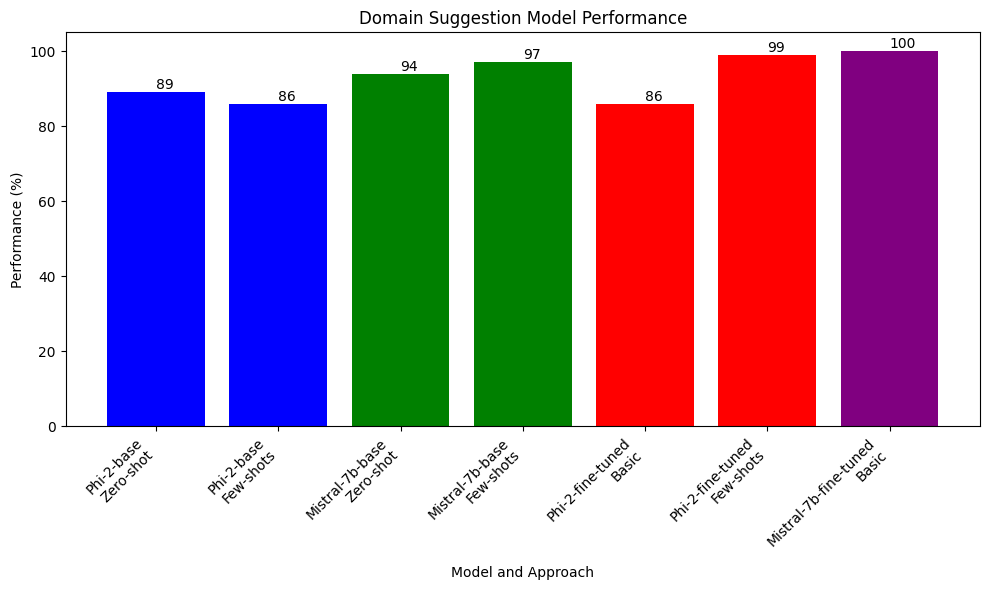

In [9]:
import matplotlib.pyplot as plt

# Data
models = ['Phi-2-base\nZero-shot', 'Phi-2-base\nFew-shots',
          'Mistral-7b-base\nZero-shot', 'Mistral-7b-base\nFew-shots',
          'Phi-2-fine-tuned\nBasic', 'Phi-2-fine-tuned\nFew-shots',
          'Mistral-7b-fine-tuned\nBasic']
performance = [89, 86, 94, 97, 86, 99, 100]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(models, performance, color=['blue', 'blue', 'green', 'green', 'red', 'red', 'purple'])

# Adding the aesthetics
plt.xlabel('Model and Approach')
plt.ylabel('Performance (%)')
plt.title('Domain Suggestion Model Performance')
plt.xticks(rotation=45, ha="right")

# Adding the annotation to bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom')  # va: vertical alignment

# Show plot
plt.tight_layout()
plt.show()


Based on JSON output consistency and output content the clear winner was - Mistral-7b-fine-tuned version.

It is deployed and can be accessed in two ways:
- HF spaces - https://huggingface.co/spaces/Soaky/DN
- Colab python API - https://github.com/LaurynasRekasius/Domain_Name_Generator/blob/main/notebooks/API_Endpoint.ipynb